Necessary Formulas:

* _for time period, allow filter over 30, 60, 90, 180, 365, custom days_
- todo: put start date and end date for COGS

### Current Monetary Stock Value: 
# $$\Sigma (Quantity of Item_i \times Unit Cost of Item)$$

### Total Items in Stock: 
# $$\Sigma (Quantity of Item_i)$$

### Low Stock Alerts: 
# $$Quantity on Hand ≤ Low Stock Threshold$$

### Out-of-Stock Items
# $$Quantity on Hand ≤ 0 AND restockFlag == 1 $$

### Overstock Items
# $$Quantity on Hand > Low Stock Threshold$$

### Upcoming Deliveries

### Recent Sales/Orders

### Returns/Damaged Goods

### Stock Movement/Velocity
#### Inflow: $$\Sigma (Quantity of Item_i received over time period)$$
#### Outflow: $$\Sigma (Quantity of Item_i sold over time period)$$

### Top Selling Products (by Quantity/Revenue)
#### By Quantity: $$\Sigma (Quantity of Item_i sold for each product over time period)$$
#### By Revenue: $$\Sigma (Quantity of Item_i sold over time period \times retailPrice over time period)$$

### Slow-Moving/Obsolete Stock: A chart or list highlighting items that haven't sold in a long time.

for each item:
# $$Current Date - Last Sale Date > Threshold$$

### Order Fulfillment Rate
# $$\frac{Number of Orders Fulfilled Completely}{Total Number of Orders} \times 100$$

### Inventory Turnover Rate
$$Inventory Turnover Rate = \frac{Cost of Goods Sold}{Average Inventory Value}$$

$$Average Inventory Value = \frac{Beginning Inventory Value + Ending Inventory Value}{2}$$

# $$Inventory Turnover Rate = \frac{Cost of Goods Sold}{\frac{Beginning Inventory Value + Ending Inventory Value}{2}}$$

### Days Sales of Inventory (DSI) / Days on Hand
# $$DSI = \frac{Ave Inventory Value}{Cost of Goods Sold} \times timePeriod$$

### Reorder Point Analysis
# $$(Ave Num Units Sold per Day \times Lead Time in Days)+Safety Stock$$
- Lead Time: Time (in days) between placing an order and receiving it.

### Safety Stock Calculation (per Product) **Might Remove**
# $$(Max Daily Sales - Average Daily Sales) \times Lead Time to buy more Products$$

### ABC Analysis

- A-Items: High-value products that account for a large percentage of total inventory value (e.g., top 10-20% of items contributing to 70-80% of value). These require close monitoring.
- B-Items: Medium-value products.
- C-Items: Low-value products that make up a large percentage of total inventory items but a small percentage of total value.

1. Calculate annual usage value for each item
# $$Annual Demand \times Unit Cost$$
2. Rank items by usage value in descending order
3. Calculate cumulative percentage of total usage value and cumulative percentage of total items
4. Define your A, B, and C cut-off points based on these cumulative percentages
- Helps prioritize inventory management efforts

### Demand Forecasting

#### Simple Moving Average: Average of sales over the last ’n’ periods
#### Regression Analysis (?????)

### Stockout Rate
# $$(Number of Stockouts \div Total Number of Order Lines) \times 100$$

### Fill Rate
# $$(Number of Orders Fulfilled on First Attempt \div Total Number of Orders) \times 100$$
- Can also be by line item or quantity
- Measures the percentage of demand that could not be met immediately from existing inventory (stockout rate) or the percentage of demand that was met successfully (fill rate).

### Return on Investment (ROI) of Inventory
# Return of Investment: $$ROI = \frac{Retail Price - Supplier Buying Price}{Supplier Buying Price}\times100%$$
# $$\frac{(Gross Profit from Sales − Cost of Holding Inventory)}{Cost of Holding Inventory}$$

### Obsolete Inventory
# $$Obsolete Inventory Value = \Sigma (Quantity of Obsolete Item_i \times Unit Cost of Item_i)$$
- The value of stock that is no longer sellable or useful

### Shrinkage Analysis
# $$Shrinkage Rate = \frac{Book Inventory Value - Physical Inventory Value}{Book Inventory Value} \times 100$$
- The loss of inventory due to factors like theft, damage, errors, or spoilage. It compares what your records say you have versus what you actually have.

# Cost of Goods Sold: $$COGS = \frac{-b \pm \sqrt{Beginning Inventory Value - 4ac}}{2a}$$

# Gross Profit: $$Revenue - COGS$$

# Set up the Python environment

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sqlalchemy import create_engine

import os
from dotenv import load_dotenv

current_dir = os.getcwd()
dotenv_path = os.path.join(current_dir, '..', 'backend', '.env')

load_dotenv(dotenv_path=dotenv_path)

my_variable = os.getenv('MY_VARIABLE')
database_url = os.getenv('DATABASE_URL')

user = os.getenv('DB_USER')
pw   = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
db   = os.getenv('DB_NAME')

engine = create_engine(f"mysql+pymysql://{user}:{pw}@{host}/{db}")

### Define the time period of the data

In [2]:
start_date = pd.to_datetime('2024-01-01')
end_date   = pd.to_datetime('2025-12-31')

# Load tables into DataFrames

In [3]:
df_products      = pd.read_sql_table("Product",      con=engine)
df_users         = pd.read_sql_table("Users",        con=engine)
df_stock_entry   = pd.read_sql_table("StockEntry",   con=engine)
df_stock_withd   = pd.read_sql_table("StockWithdrawal", con=engine)
df_orders        = pd.read_sql_table("Orders",       con=engine)
df_order_info    = pd.read_sql_table("OrderInfo",    con=engine)
df_returns       = pd.read_sql_table("ReturnExchange",     con=engine)
df_return_info   = pd.read_sql_table("ReturnExchangeInfo", con=engine)
df_audit         = pd.read_sql_table("AuditLog",     con=engine)

# Compute Cost of Goods Sold (COGS) per product

In [4]:
# 2a. Only “paid” orders
paid_orders = df_orders[df_orders['paymentStatus']=='paid']

# 2b. Join orders → order lines → product costs
sales = (
    paid_orders[['orderId', 'dateOrdered']]
    .merge(df_order_info, on='orderId')
    .merge(df_products[['productId', 'cost', 'productName']], on='productId')
)

# 2c. Filter to period and compute COGS
sales['dateOrdered'] = pd.to_datetime(sales['dateOrdered'])
sales_period = sales[(sales['dateOrdered'] >= start_date) & (sales['dateOrdered'] <= end_date)]
sales_period['cogs'] = sales_period['quantity'] * sales_period['cost']

# 2d. Total COGS per product
cogs_per_prod = (sales_period
    .groupby(['productId','productName'])['cogs']
    .sum()
    .rename('total_cogs')
    .reset_index()
)

print("Total COGS per product:")
print(cogs_per_prod)

Total COGS per product:
    productId productName  total_cogs
0           3   Product 3     4881.86
1           6   Product 6     3711.84
2           9   Product 9     4275.18
3          11  Product 11      536.50
4          14  Product 14      829.44
5          17  Product 17     4812.16
6          20  Product 20     5088.27
7          23  Product 23     2736.80
8          26  Product 26     3646.58
9          29  Product 29     4536.52
10         32  Product 32      690.46
11         35  Product 35     1650.25
12         38  Product 38      933.80
13         41  Product 41     3862.32
14         44  Product 44     3365.70
15         47  Product 47     2700.66
16         50  Product 50     3811.08


## Compute beginning & ending inventory levels

In [5]:
# 3a. Beginning on-hand = total received – total withdrawn **before** start_date
# Map withdrawals → productId
withdrawals = (
    df_stock_withd[['entryId','quantityWithdrawn','dateWithdrawn']]
    .merge(df_stock_entry[['entryId','productId']], on='entryId')
)
# Sum
received_before = (df_stock_entry[df_stock_entry['dateReceived'] < start_date]
    .groupby('productId')['quantityReceived']
    .sum()
    .rename('total_received_before')
)
withdrawn_before = (withdrawals[pd.to_datetime(withdrawals['dateWithdrawn']) < start_date]
    .groupby('productId')['quantityWithdrawn']
    .sum()
    .rename('total_withdrawn_before')
)
beg_inv = (received_before.subtract(withdrawn_before, fill_value=0)
           .reset_index().rename(columns={0:'beg_units', 'total_received_before':'beg_units'}))

# 3b. Ending on-hand from current snapshot
end_inv = df_products[['productId','productName','stockOnHand','cost']]


## Build the turnover table

In [6]:
# Merge beginning, ending, and COGS
turnover = (
    cogs_per_prod
    .merge(beg_inv,  on=['productId'], how='left')
    .merge(end_inv,  on=['productId','productName'], how='left')
    .fillna(0)
)

# Average units and average inventory **value**
turnover['avg_units'] = (turnover['beg_units'] + turnover['stockOnHand']) / 2
turnover['avg_inventory_value'] = turnover['avg_units'] * turnover['cost']

# Turnover rate per product
turnover['turnover_rate'] = turnover['total_cogs'] / turnover['avg_inventory_value']

print("Turnover rate per product:")
print(turnover[['productId', 'productName', 'turnover_rate']])


Turnover rate per product:
    productId productName  turnover_rate
0           3   Product 3       1.468354
1           6   Product 6       2.838710
2           9   Product 9       3.500000
3          11  Product 11       1.219512
4          14  Product 14       1.113402
5          17  Product 17       4.709677
6          20  Product 20       1.186047
7          23  Product 23       1.012658
8          26  Product 26       8.166667
9          29  Product 29       2.000000
10         32  Product 32      23.000000
11         35  Product 35       1.012346
12         38  Product 38       1.877551
13         41  Product 41       5.739130
14         44  Product 44      65.000000
15         47  Product 47       1.672727
16         50  Product 50       2.418605


/var/folders/hv/jnmd_b7123gfd5f464464gh80000gn/T/ipykernel_75256/2361431120.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(0)


## Visualize: Top 10 Products by Turnover Rate

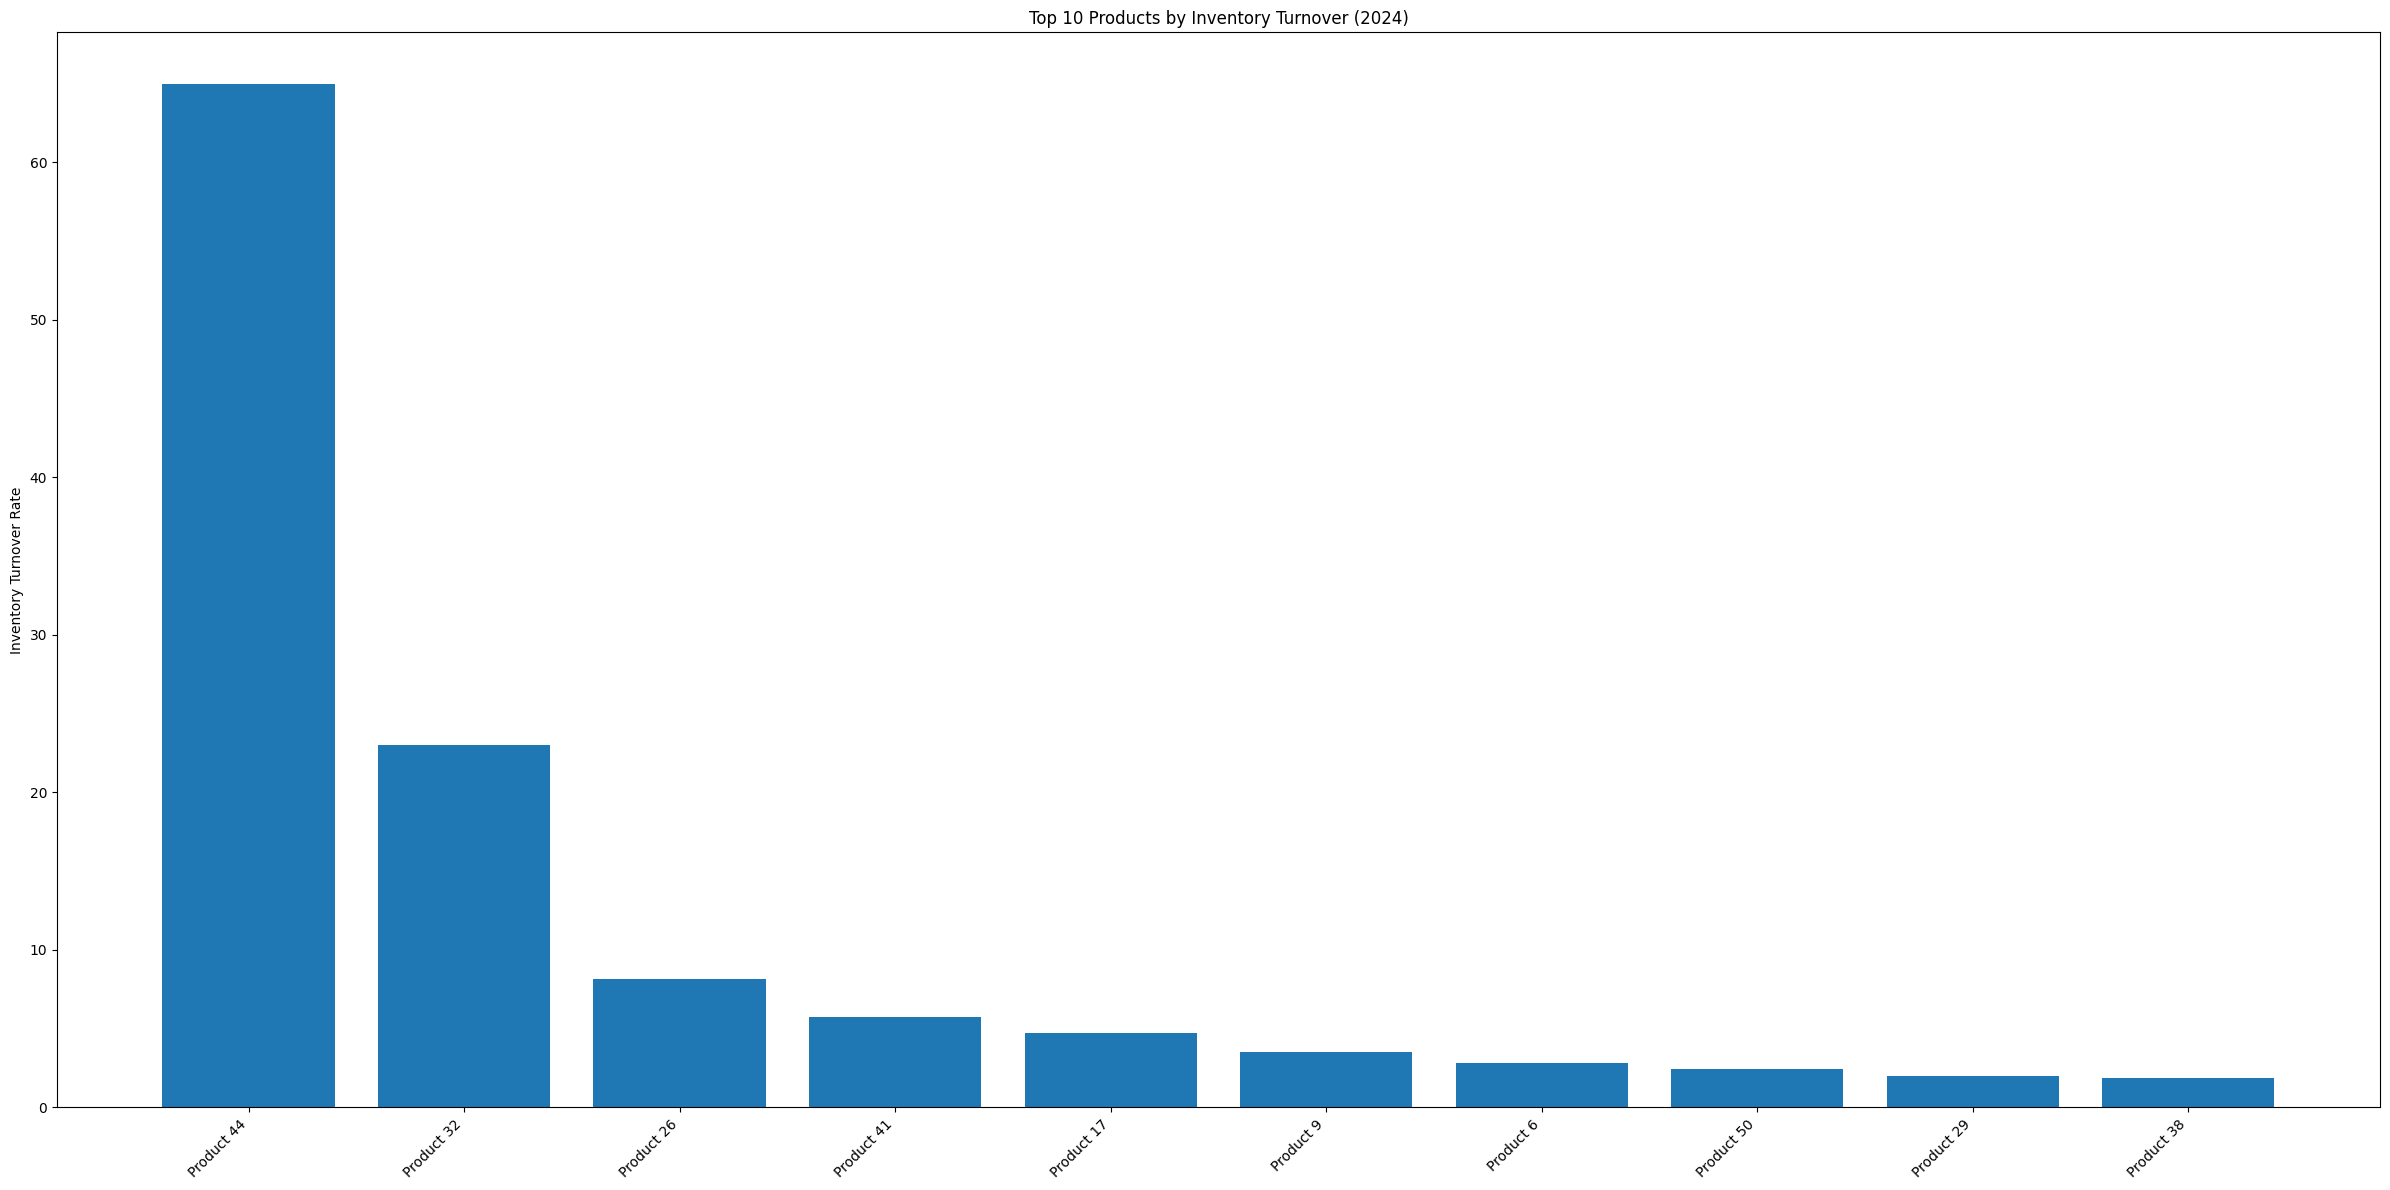

In [7]:
top10 = turnover.sort_values('turnover_rate', ascending=False).head(10)

plt.figure(figsize=(24,12))
plt.bar(top10['productName'], top10['turnover_rate'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Inventory Turnover Rate')
plt.title('Top 10 Products by Inventory Turnover (2024)')
plt.tight_layout()
plt.show()


# Stock-level snapshots

## Current Monetary Stock Value

In [8]:
# add a column for the value on hand per product
df_products['monetaryValue'] = df_products['stockOnHand'] * df_products['cost']

# overall monetary value
current_monetary_value = df_products['monetaryValue'].sum()
print(f"Current monetary stock value: ₱{current_monetary_value:,.2f}")


Current monetary stock value: ₱14,213,292.59


## Total Items in Stock

In [9]:
total_items = df_products['stockOnHand'].sum()
print(f"Total units in stock: {total_items:,}")

Total units in stock: 27,193


## Total Items per Product

In [10]:
total_items_per_product = df_products[['productId', 'productName', 'stockOnHand']].copy()
total_items_per_product.rename(columns={'stockOnHand': 'total_items'}, inplace=True)
print("Total Items per Product:")
print(total_items_per_product)

Total Items per Product:
     productId             productName  total_items
0            1               Product 1           90
1            2               Product 2           94
2            3               Product 3           79
3            4               Product 4           44
4            5               Product 5           22
..         ...                     ...          ...
876        888            2 STAR WHITE           10
877        889   STIGA DNA DRAGON GRIP           10
878        890        JAPTEC PRECISION           10
879        891  3 STAR ADIDAS KEYCHAIN           10
880        892         LKT 2828 CARBON           10

[881 rows x 3 columns]


## Low-Stock Alerts

     productId             productName  stockOnHand
0            1               Product 1           90
4            5               Product 5           22
6            7               Product 7           14
7            8               Product 8            8
8            9               Product 9           36
..         ...                     ...          ...
876        888            2 STAR WHITE           10
877        889   STIGA DNA DRAGON GRIP           10
878        890        JAPTEC PRECISION           10
879        891  3 STAR ADIDAS KEYCHAIN           10
880        892         LKT 2828 CARBON           10

[625 rows x 3 columns]


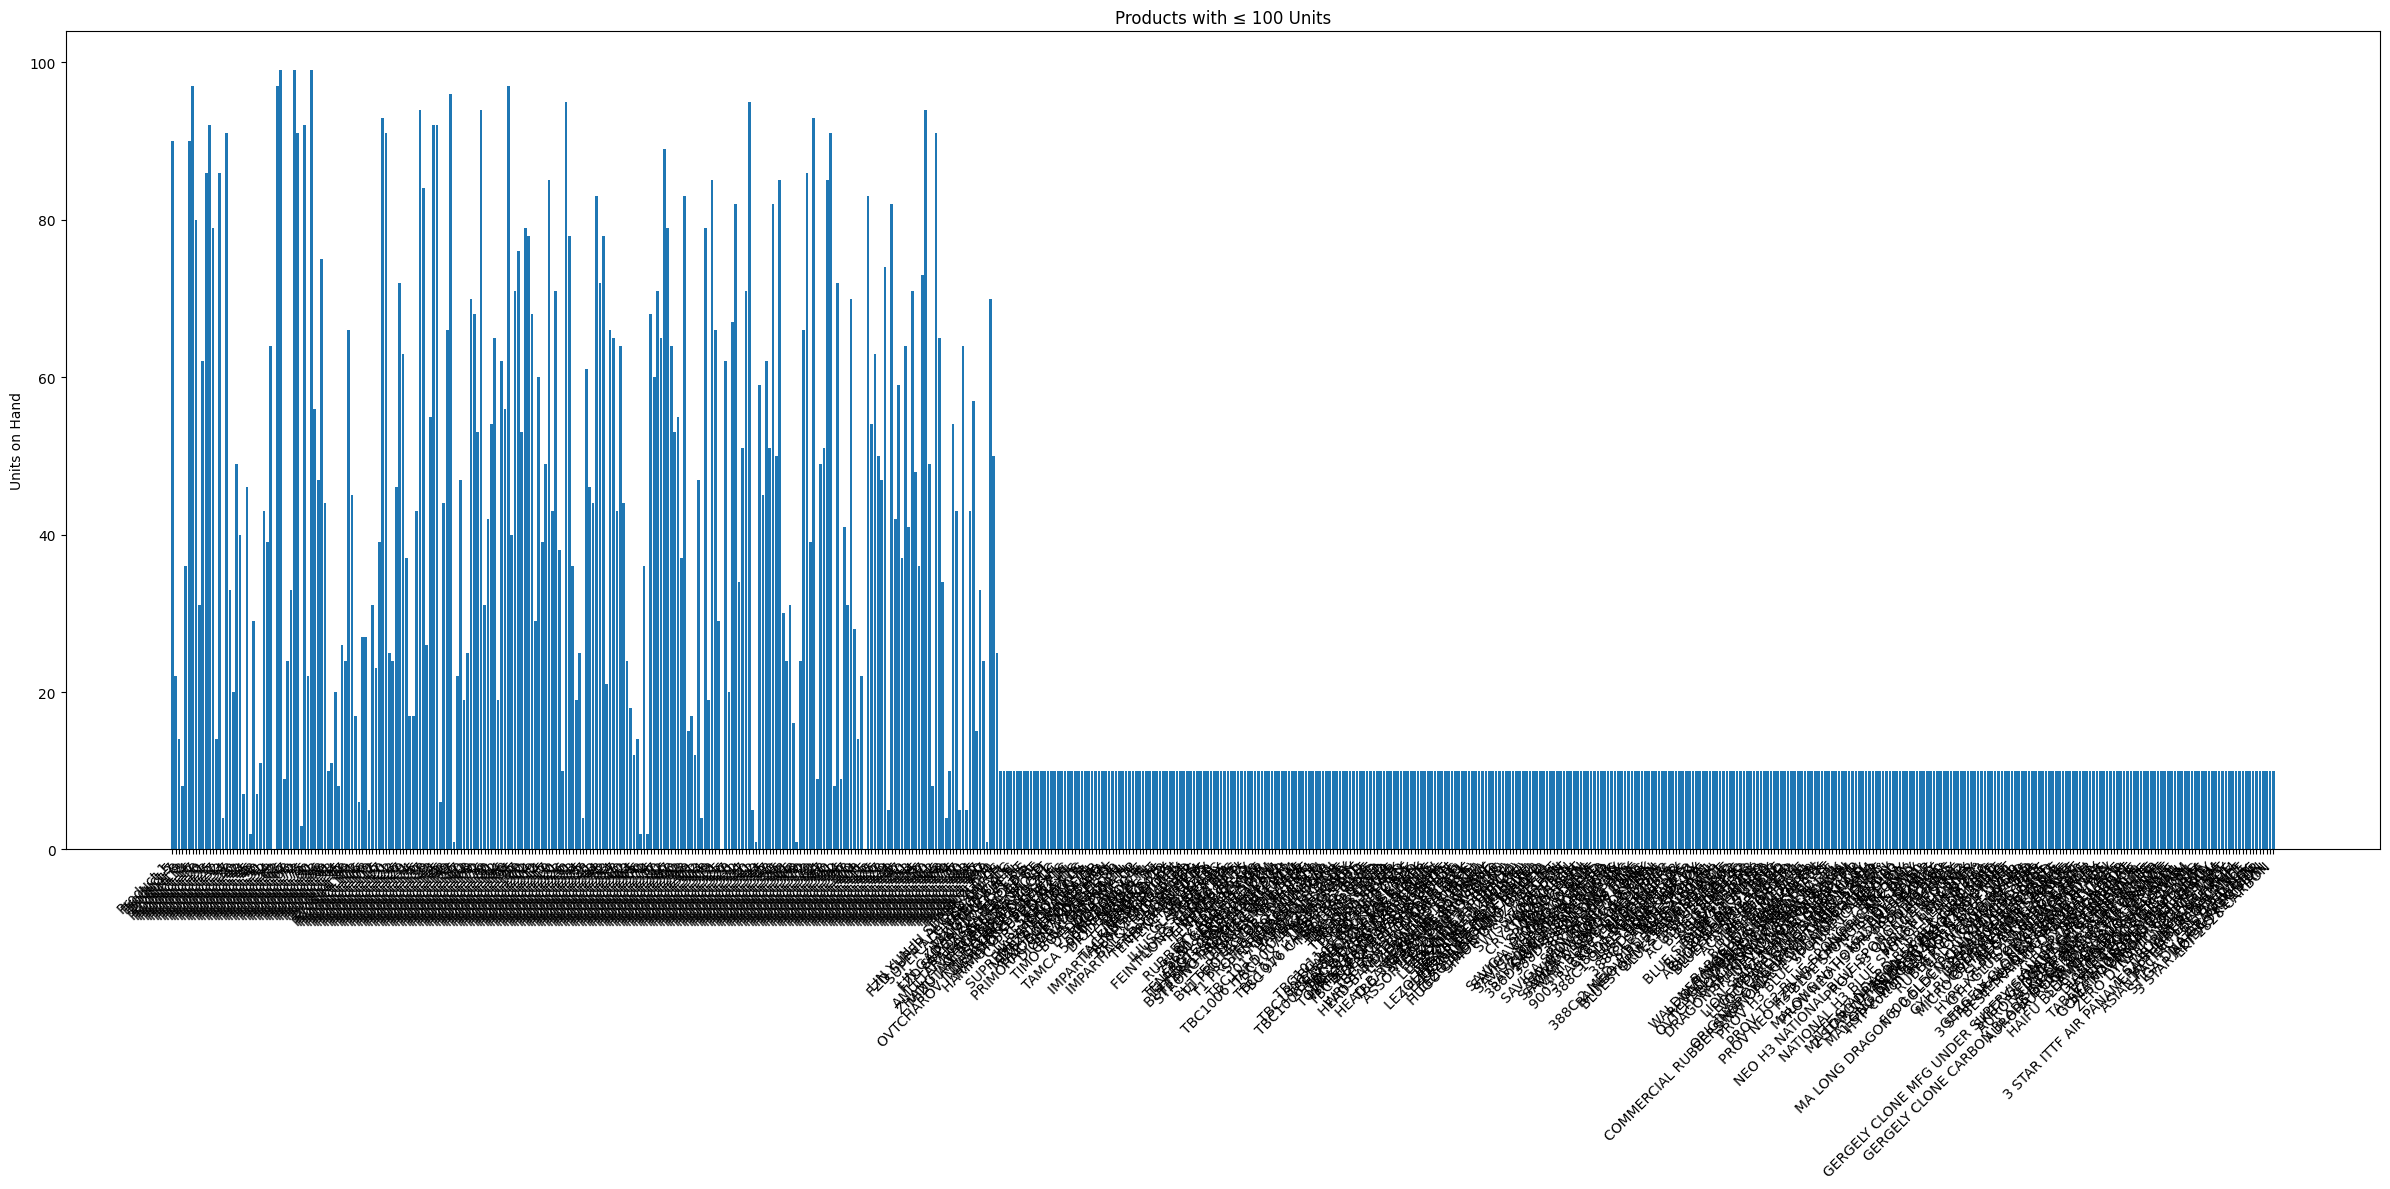

In [11]:
low_stock_threshold = 100
low_stock = df_products[(df_products['stockOnHand'] <= low_stock_threshold) &
                        (df_products['restockFlag'] != 1)
                        ]

# list
print(low_stock[['productId','productName','stockOnHand']])

# bar chart
plt.figure(figsize=(24,12))
plt.bar(low_stock['productName'], low_stock['stockOnHand'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Units on Hand')
plt.title(f'Products with ≤ {low_stock_threshold} Units')
plt.tight_layout()
plt.show()

## Out‐of‐Stock Items

In [12]:
out_of_stock = df_products[(df_products['stockOnHand'] == 0) & (df_products['restockFlag'] != 1)]

print(out_of_stock[['productId','productName']])


     productId  productName
53          54   Product 54
320        321  Product 321
407        408  Product 408


## Overstock Items

In [13]:
overstock_threshold = 50
overstock = df_products[df_products['stockOnHand'] >= overstock_threshold]
print(overstock[['productId','productName','stockOnHand']])


     productId  productName  stockOnHand
0            1    Product 1           90
1            2    Product 2           94
2            3    Product 3           79
10          11   Product 11           82
12          13   Product 13           90
..         ...          ...          ...
493        494  Product 494           80
494        495  Product 495           83
496        497  Product 497           70
497        498  Product 498           60
498        499  Product 499           50

[222 rows x 3 columns]


# Deliveries, Sales & Returns

## Upcoming Deliveries

In [14]:
now = pd.Timestamp.now().normalize()
upcoming = df_stock_entry[pd.to_datetime(df_stock_entry['dateReceived']) >= now]
print(upcoming.sort_values('dateReceived')[['productId','branchName','dateReceived','quantityReceived']])


Empty DataFrame
Columns: [productId, branchName, dateReceived, quantityReceived]
Index: []


## Recent Sales / Orders

In [15]:
cutoff = now - pd.Timedelta(days=30)
recent = sales[(sales['dateOrdered'] >= cutoff)]

# # orders
print(f"Paid orders in last 30d: {recent['orderId'].nunique()}")

# total revenue
recent = recent.assign(revenue = recent['quantity'] * recent['unitPriceAtPurchase'])
print(f"Sales revenue last 30d: ₱{recent['revenue'].sum():,.2f}")


Paid orders in last 30d: 17
Sales revenue last 30d: ₱46,464.32


## Returns / Damaged Goods

In [16]:
# join return header + details
returns = (
    df_returns[['transactionId','dateTransaction','transactionStatus']]
    .merge(df_return_info, on='transactionId')
    .merge(df_products[['productId','productName']], left_on='returnedProductId', right_on='productId')
)
print(returns[['transactionId','dateTransaction','productName','returnedQuantity','transactionStatus']])


     transactionId dateTransaction productName  returnedQuantity  \
0                1      2025-07-20   Product 7                 2   
1                2      2025-07-19   Product 8                 2   
2                3      2025-07-18   Product 9                 2   
3                4      2025-07-17  Product 10                 4   
4                5      2025-07-16  Product 11                 2   
..             ...             ...         ...               ...   
495            496      2025-07-05   Product 2                 5   
496            497      2025-07-04   Product 3                 1   
497            498      2025-07-03   Product 4                 2   
498            499      2025-07-02   Product 5                 4   
499            500      2025-07-01   Product 6                 2   

    transactionStatus  
0            replaced  
1              denied  
2            refunded  
3            replaced  
4              denied  
..                ...  
495          re

# Movement / Velocity & Top/Slow Movers

## Stock Movement / Velocity

Daily in vs. out over the period:

Stock In vs. Stock Out (Time-series)

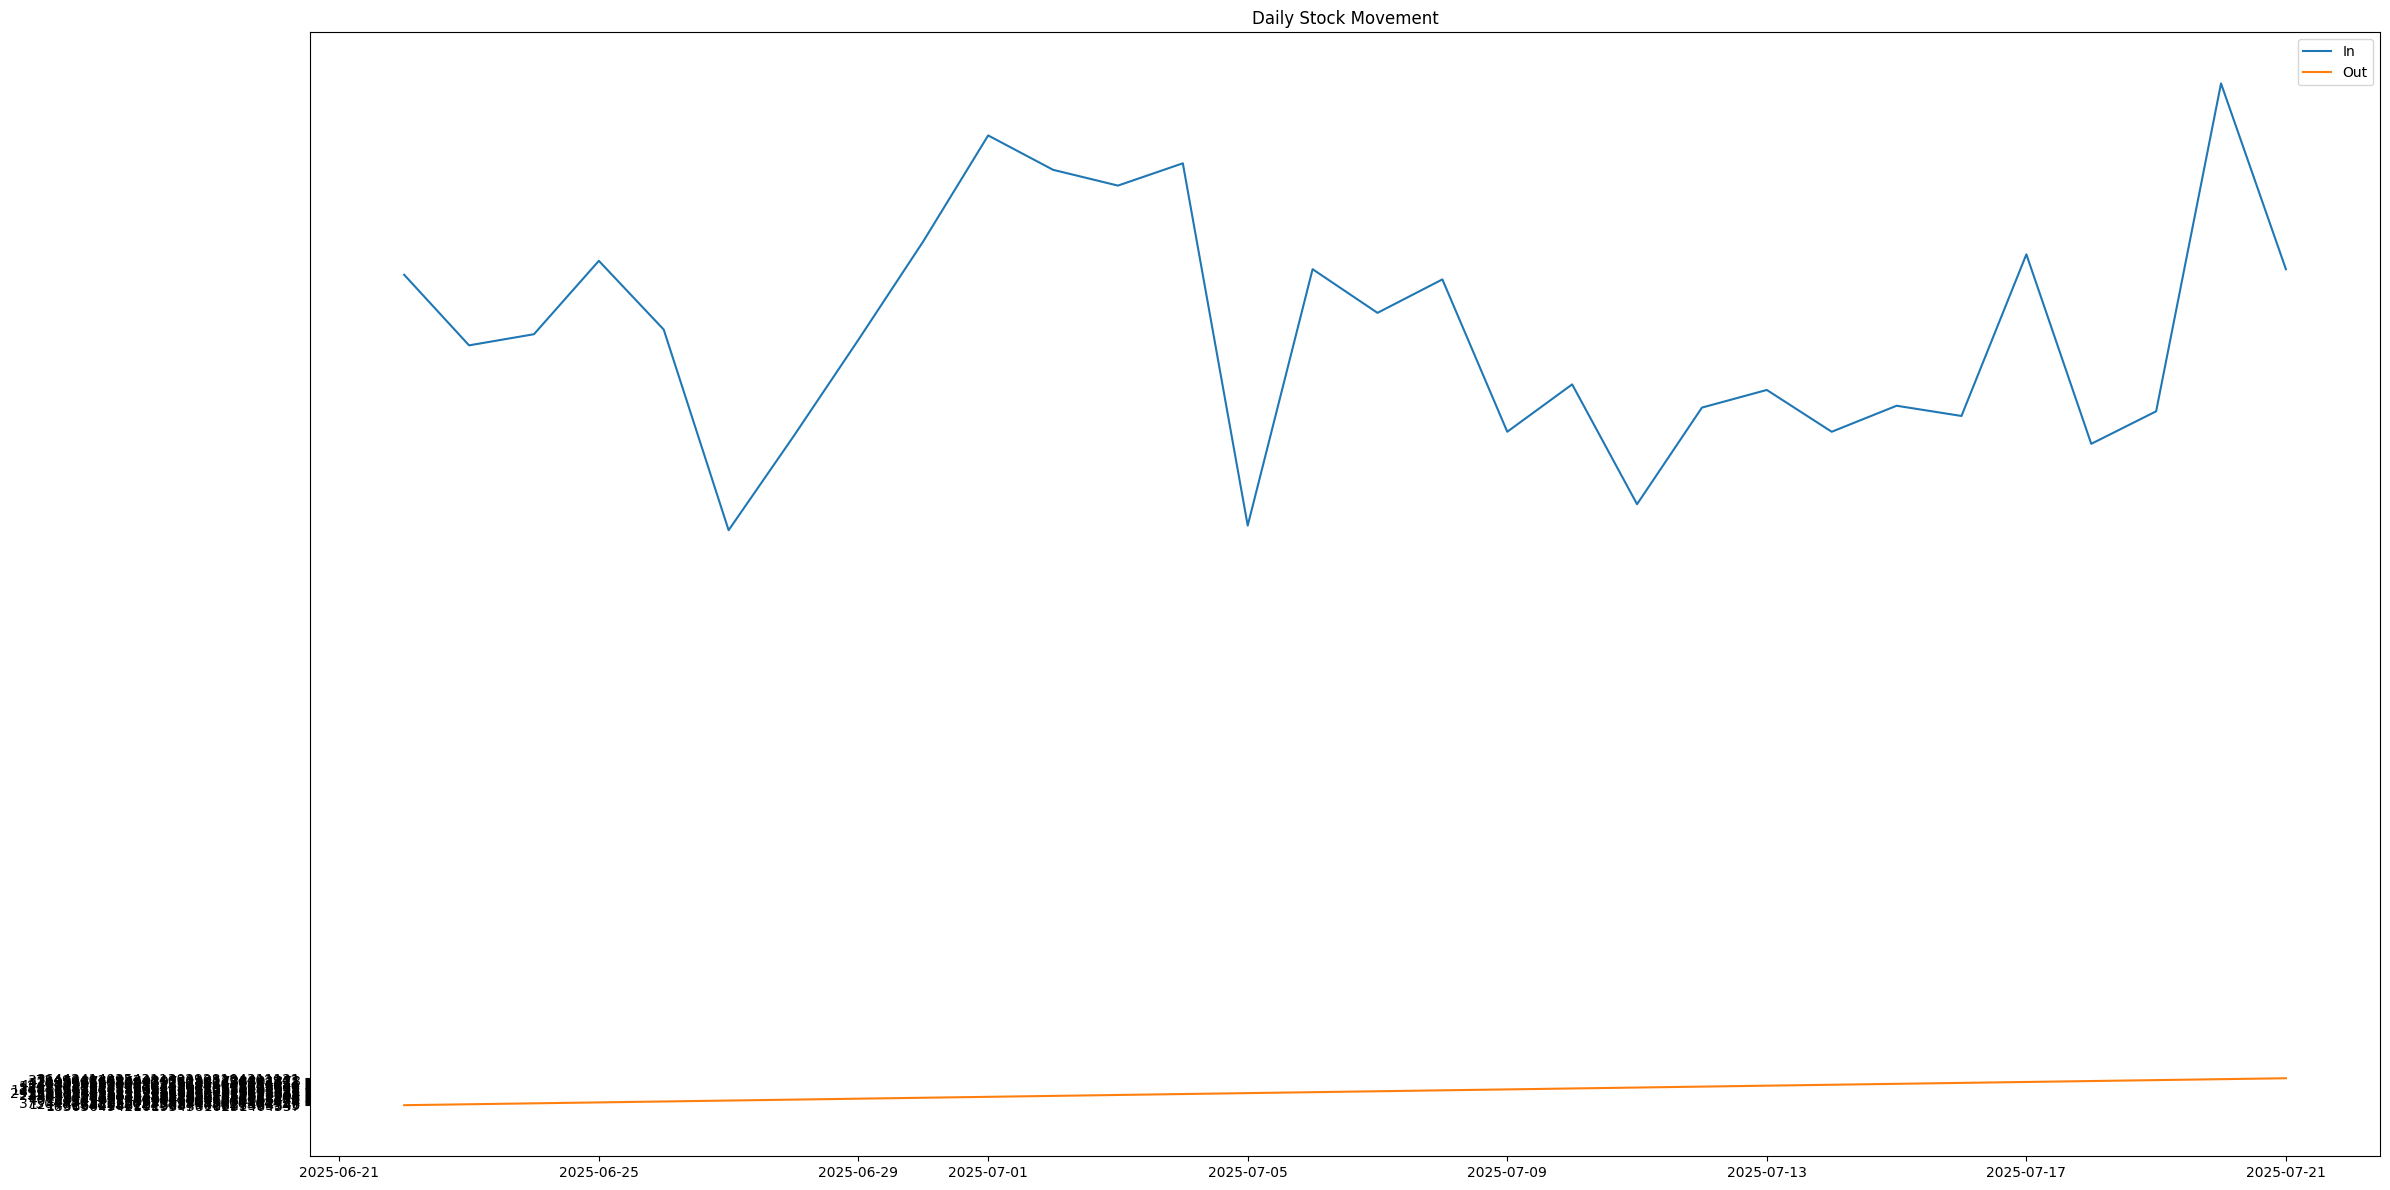

In [17]:
# prepare
in_ = df_stock_entry.assign(date=pd.to_datetime(df_stock_entry['dateReceived']))
out = (
    df_stock_withd.rename(columns={'dateWithdrawn':'date','quantityWithdrawn':'qty'})
    .merge(df_stock_entry[['entryId','productId']], on='entryId')
    .assign(date=lambda d: pd.to_datetime(d['date']))
)

# aggregate & resample
daily_in  = in_.set_index('date')['quantityReceived'].resample('D').sum().fillna(0)
daily_out = out.set_index('date')['qty'].resample('D').sum().fillna(0)

# plot
plt.figure(figsize=(24,12))
plt.plot(daily_in.index, daily_in, label='In')
plt.plot(daily_out.index, daily_out, label='Out')
plt.legend(); plt.title('Daily Stock Movement'); plt.tight_layout()
plt.show()


## Top-Selling Products


by quantity

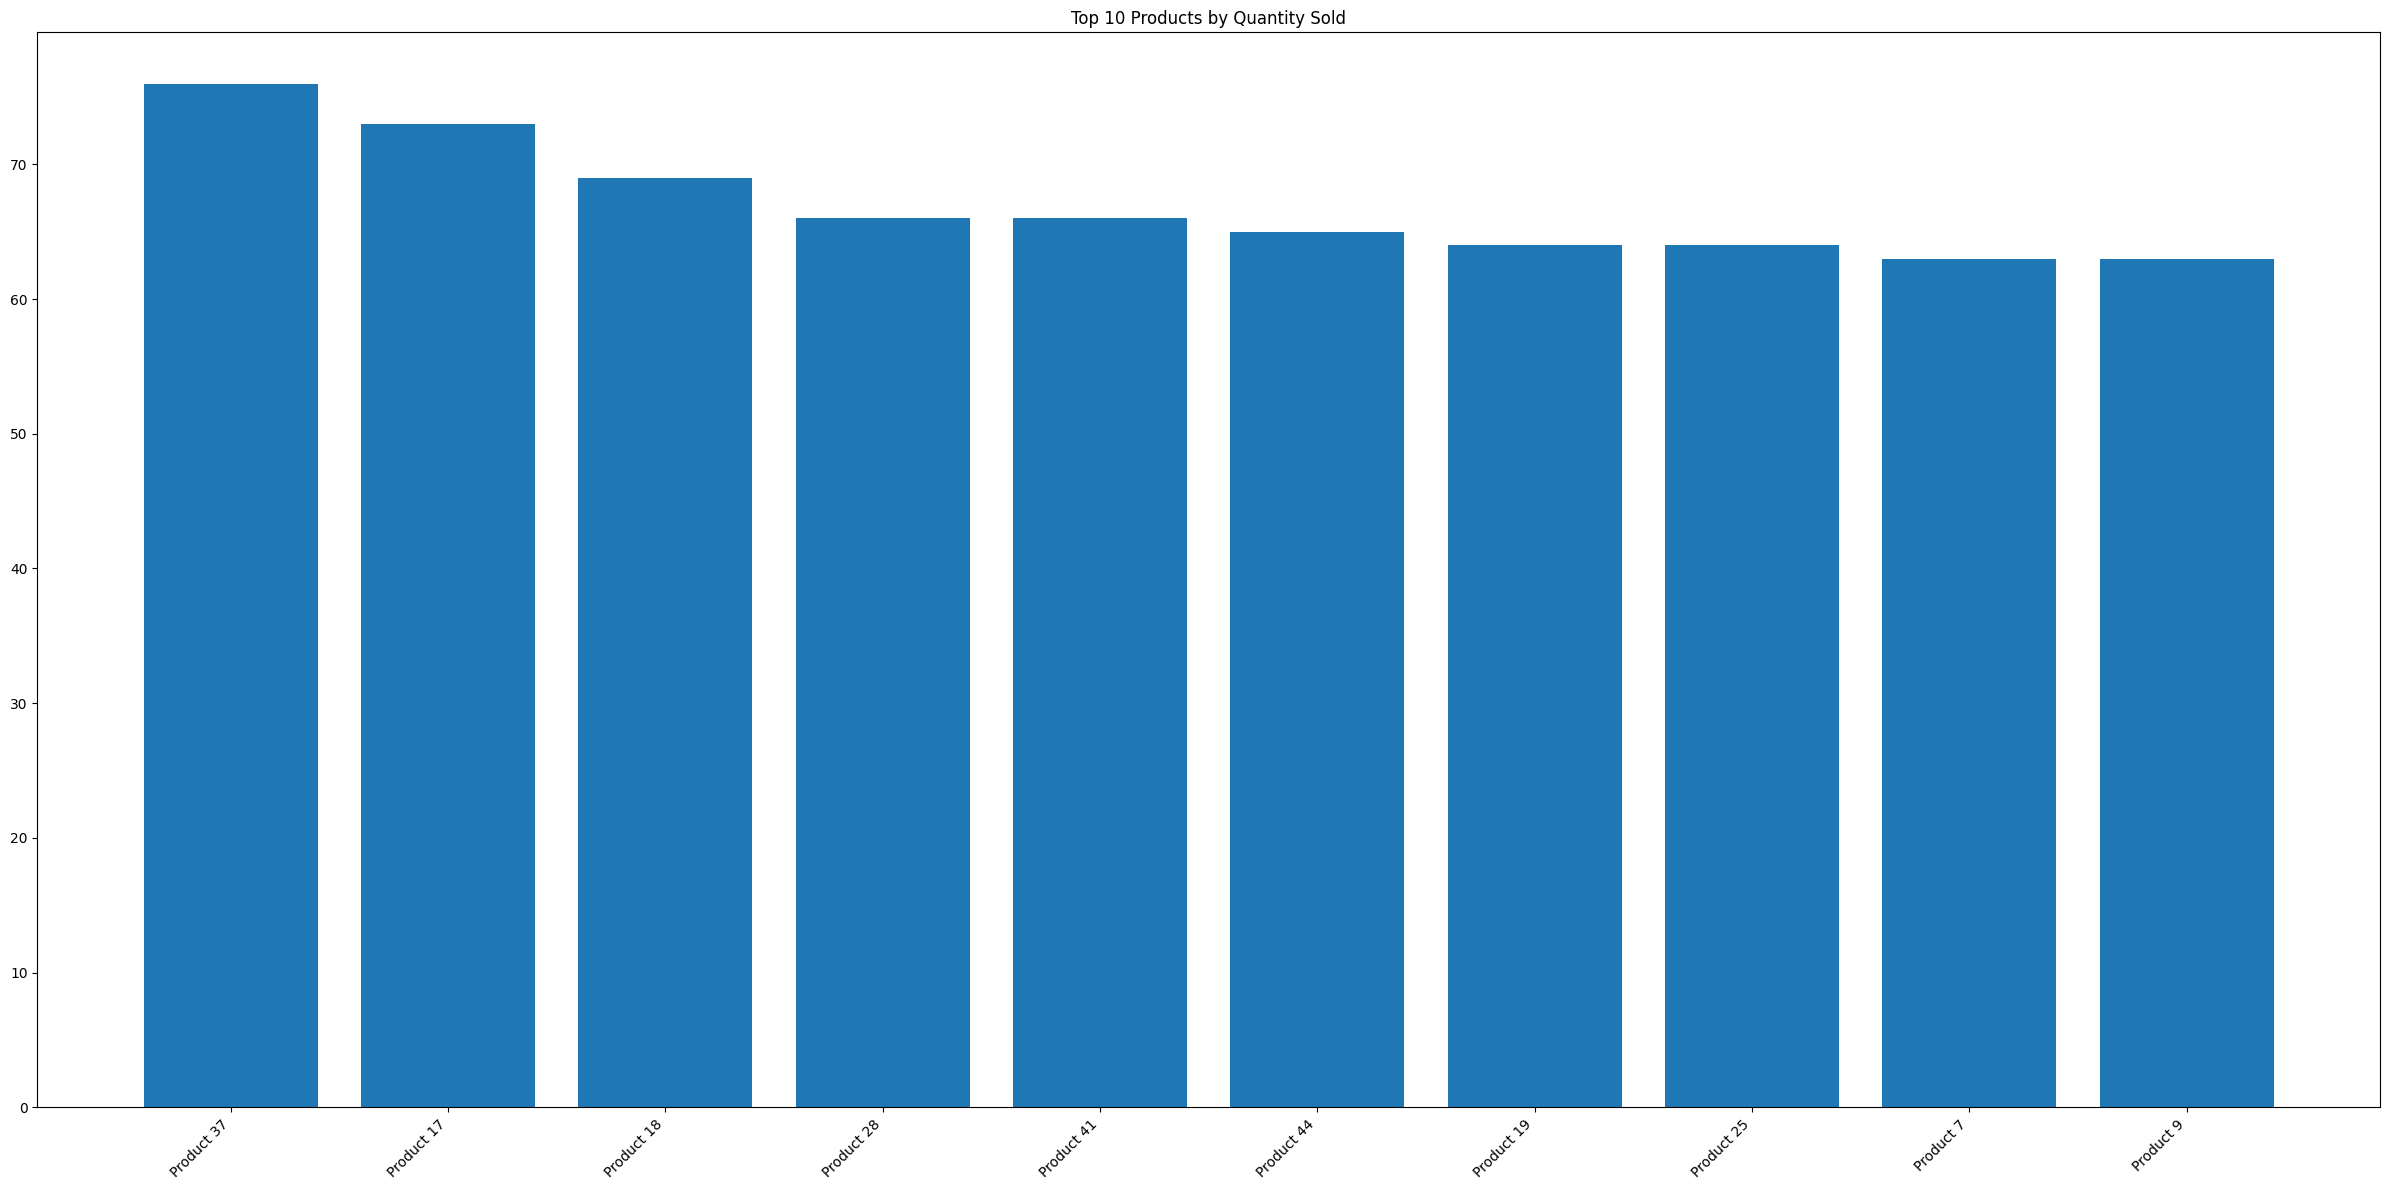

In [18]:
top_qty = (
    df_order_info
    .groupby('productId')['quantity']
    .sum()
    .nlargest(10)
    .reset_index()
    .merge(df_products[['productId','productName']], on='productId')
)
plt.figure(figsize=(24,12))
plt.bar(top_qty['productName'], top_qty['quantity'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Products by Quantity Sold')
plt.tight_layout()
plt.show()


by revenue

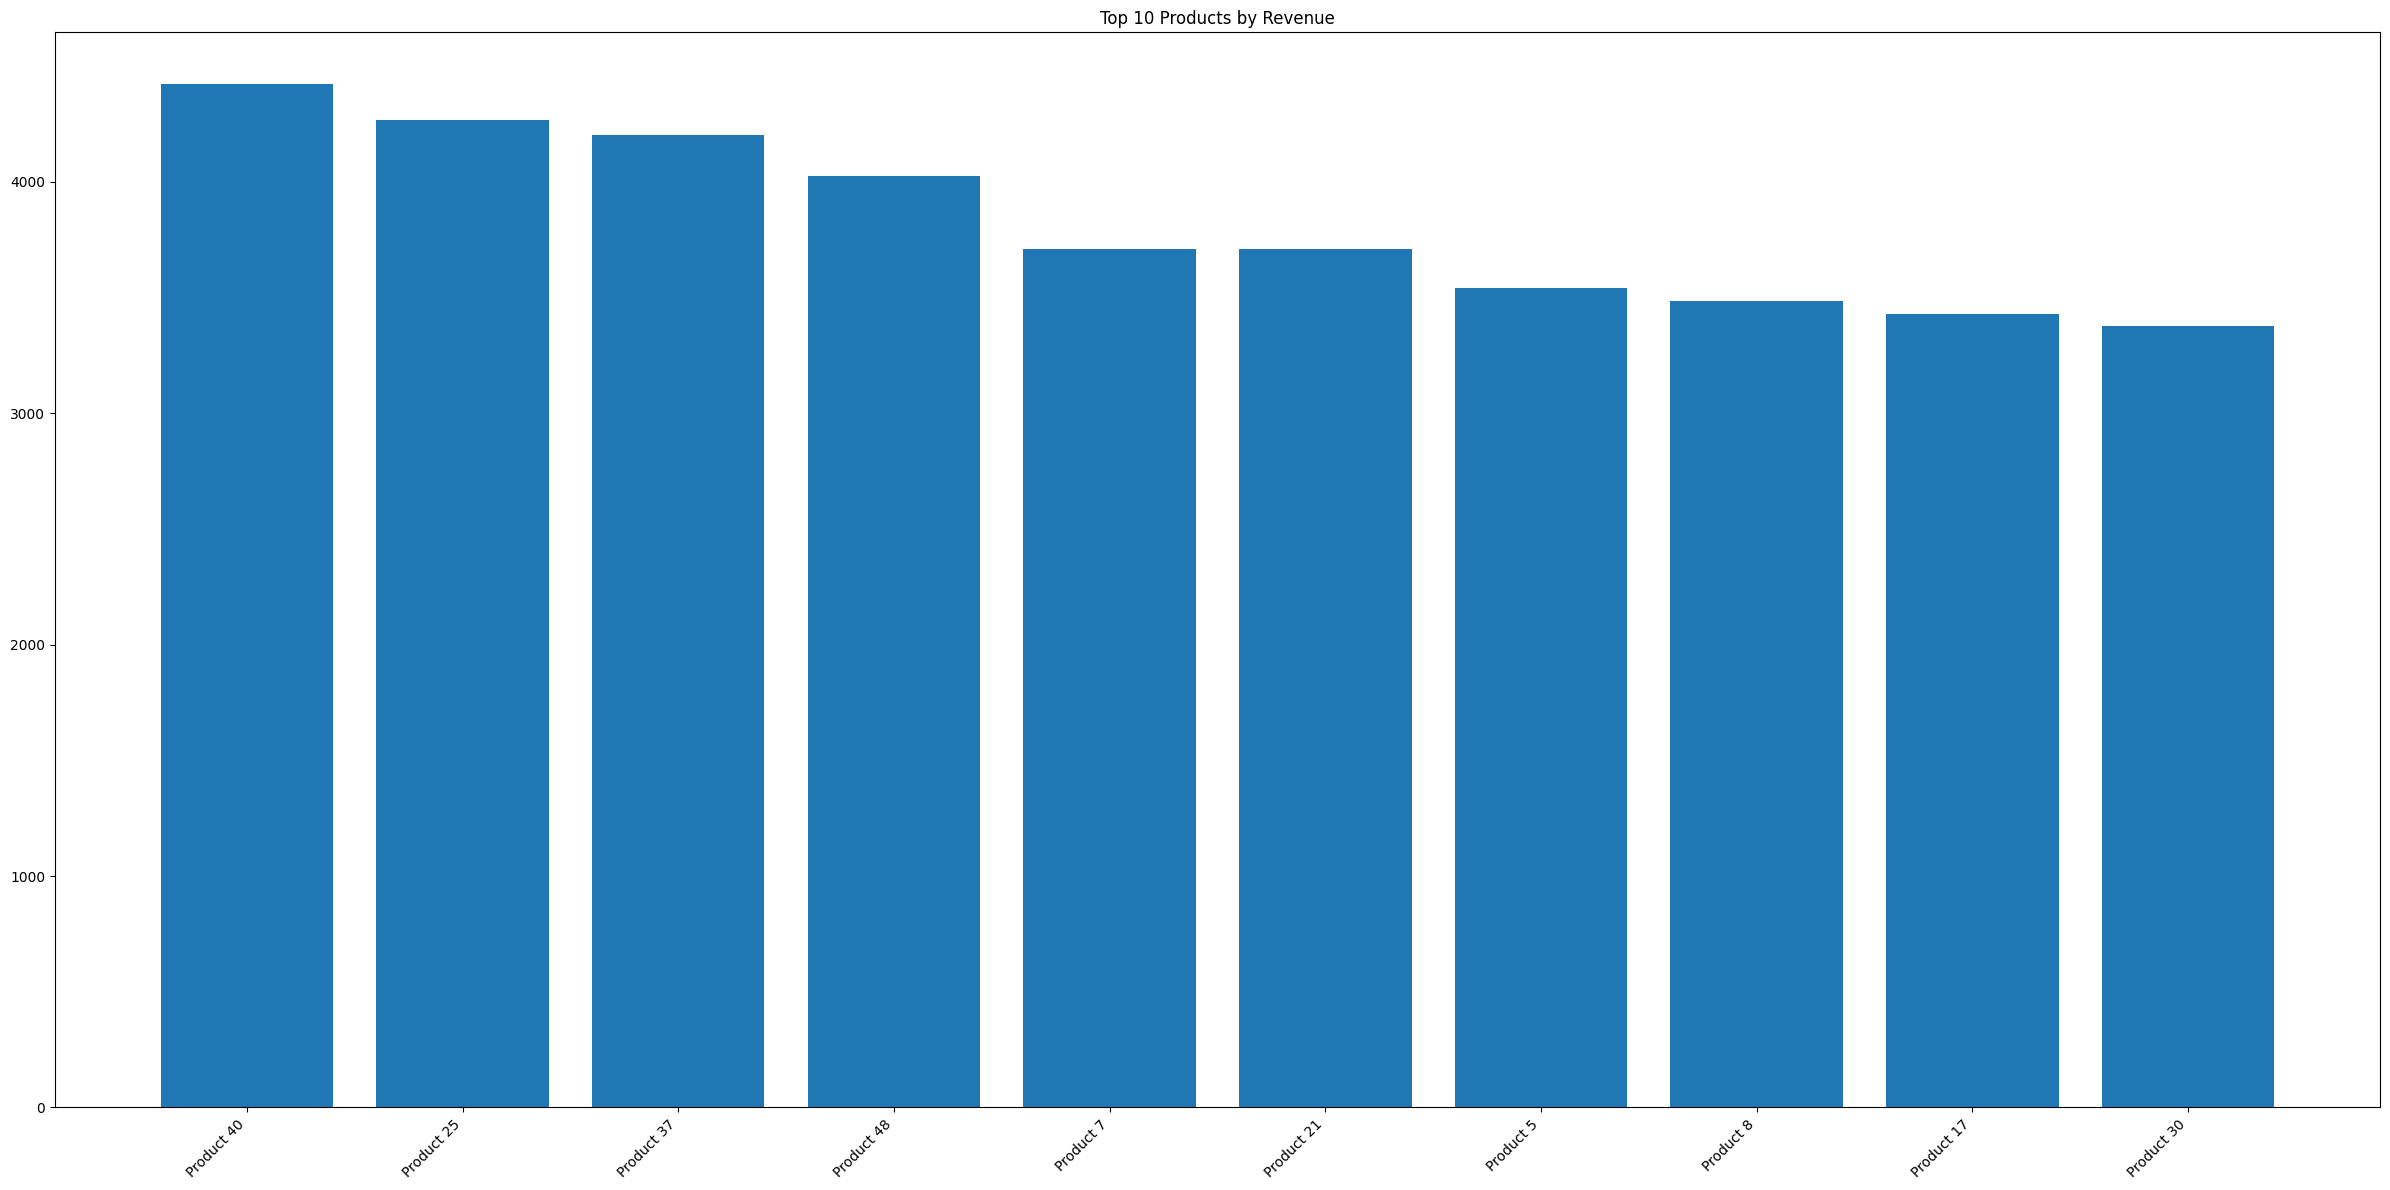

In [19]:
rev = df_order_info.assign(revenue=df_order_info['quantity']*df_order_info['unitPriceAtPurchase'])
top_rev = (
    rev.groupby('productId')['revenue']
    .sum()
    .nlargest(10)
    .reset_index()
    .merge(df_products[['productId','productName']], on='productId')
)
plt.figure(figsize=(24,12))
plt.bar(top_rev['productName'], top_rev['revenue'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Products by Revenue')
plt.tight_layout()
plt.show()


## Slow-Moving / Obsolete Stock

no sales in last 90 days

In [20]:
# make sure 'now' is defined
now = pd.Timestamp.now().normalize()

# 1) get last sale date per product
last_sale = (
    sales
      .groupby('productId')['dateOrdered']
      .max()
      .reset_index()
)

# 2) ensure it's datetime (often already is)
last_sale['dateOrdered'] = pd.to_datetime(last_sale['dateOrdered'])

# 3) compute days since last sale
last_sale['days_since'] = (now - last_sale['dateOrdered']).dt.days

# 4) filter and merge
slow = (
    last_sale[last_sale['days_since'] > 90]
      .merge(df_products[['productId','productName','stockOnHand']],
             on='productId')
)

print(slow[['productName','stockOnHand','days_since']])


Empty DataFrame
Columns: [productName, stockOnHand, days_since]
Index: []


In [21]:
now = pd.Timestamp.now().normalize()

last_sale = (
    sales
      .groupby('productId')['dateOrdered']
      .max()
      .reset_index()
      .assign(
        # convert the new column to datetime
        dateOrdered=lambda df: pd.to_datetime(df['dateOrdered']),
        # then compute days_since from that
        days_since = lambda df: (now - df['dateOrdered']).dt.days
      )
)

slow = last_sale[last_sale['days_since'] > 90] \
         .merge(df_products[['productId','productName','stockOnHand']],
                on='productId')

print(slow[['productName','stockOnHand','days_since']])


Empty DataFrame
Columns: [productName, stockOnHand, days_since]
Index: []


# Fulfillment & Inventory Ratios

## Order Fulfillment Rate

If “paid” = fulfilled IDK AAAAAAAA

In [22]:
total_orders = df_orders.shape[0]
fulfilled    = paid_orders.shape[0]
rate = fulfilled / total_orders * 100
print(f"Fulfillment Rate: {rate:.1f}%")


Fulfillment Rate: 33.4%


## Inventory Turnover Rate

In [23]:
overall_turnover = sales_period['cogs'].sum() / turnover['avg_inventory_value'].sum()
print(f"Overall Inv. Turnover Rate: {overall_turnover:.2f}")


Overall Inv. Turnover Rate: 2.18


## Days Sales of Inventory (DSI) / Days on Hand

In [24]:
period_days = (end_date - start_date).days
total_cogs = sales_period['cogs'].sum()
avg_inv_val = turnover['avg_inventory_value'].sum()
DSI = avg_inv_val / (total_cogs / period_days)
print(f"Days Sales of Inventory: {DSI:.1f} days")


Days Sales of Inventory: 334.2 days


## Reorder Point & Safety Stock

In [25]:
# avg daily usage per product
daily_usage = sales_period.groupby('productId')['quantity'].sum() / period_days

lead_time_days = 7  # example
# assume safety_stock pre‐computed or constant:
safety_stock = 20

reorder_point = (daily_usage * lead_time_days + safety_stock).rename('reorderPoint').reset_index()
print(reorder_point.merge(df_products[['productId','productName']], on='productId'))


    productId  reorderPoint productName
0           3     20.556164   Product 3
1           6     20.421918   Product 6
2           9     20.604110   Product 9
3          11     20.479452  Product 11
4          14     20.517808  Product 14
5          17     20.700000  Product 17
6          20     20.489041  Product 20
7          23     20.383562  Product 23
8          26     20.469863  Product 26
9          29     20.441096  Product 29
10         32     20.441096  Product 32
11         35     20.393151  Product 35
12         38     20.441096  Product 38
13         41     20.632877  Product 41
14         44     20.623288  Product 44
15         47     20.441096  Product 47
16         50     20.498630  Product 50


## Safety Stock Calculation

Using service‐level z and usage variability

In [26]:
# daily usage series
du = sales.set_index('dateOrdered').groupby('productId')['quantity'].resample('D').sum().fillna(0)
std_usage = du.groupby('productId').std()

z = 1.65  # ~95% service level
ss = (z * std_usage * np.sqrt(lead_time_days)).rename('safetyStock').reset_index()
print(ss.head())


   productId  safetyStock
0          3          NaN
1          6          NaN
2          9          NaN
3         11          NaN
4         14          NaN


## ABC Analysis

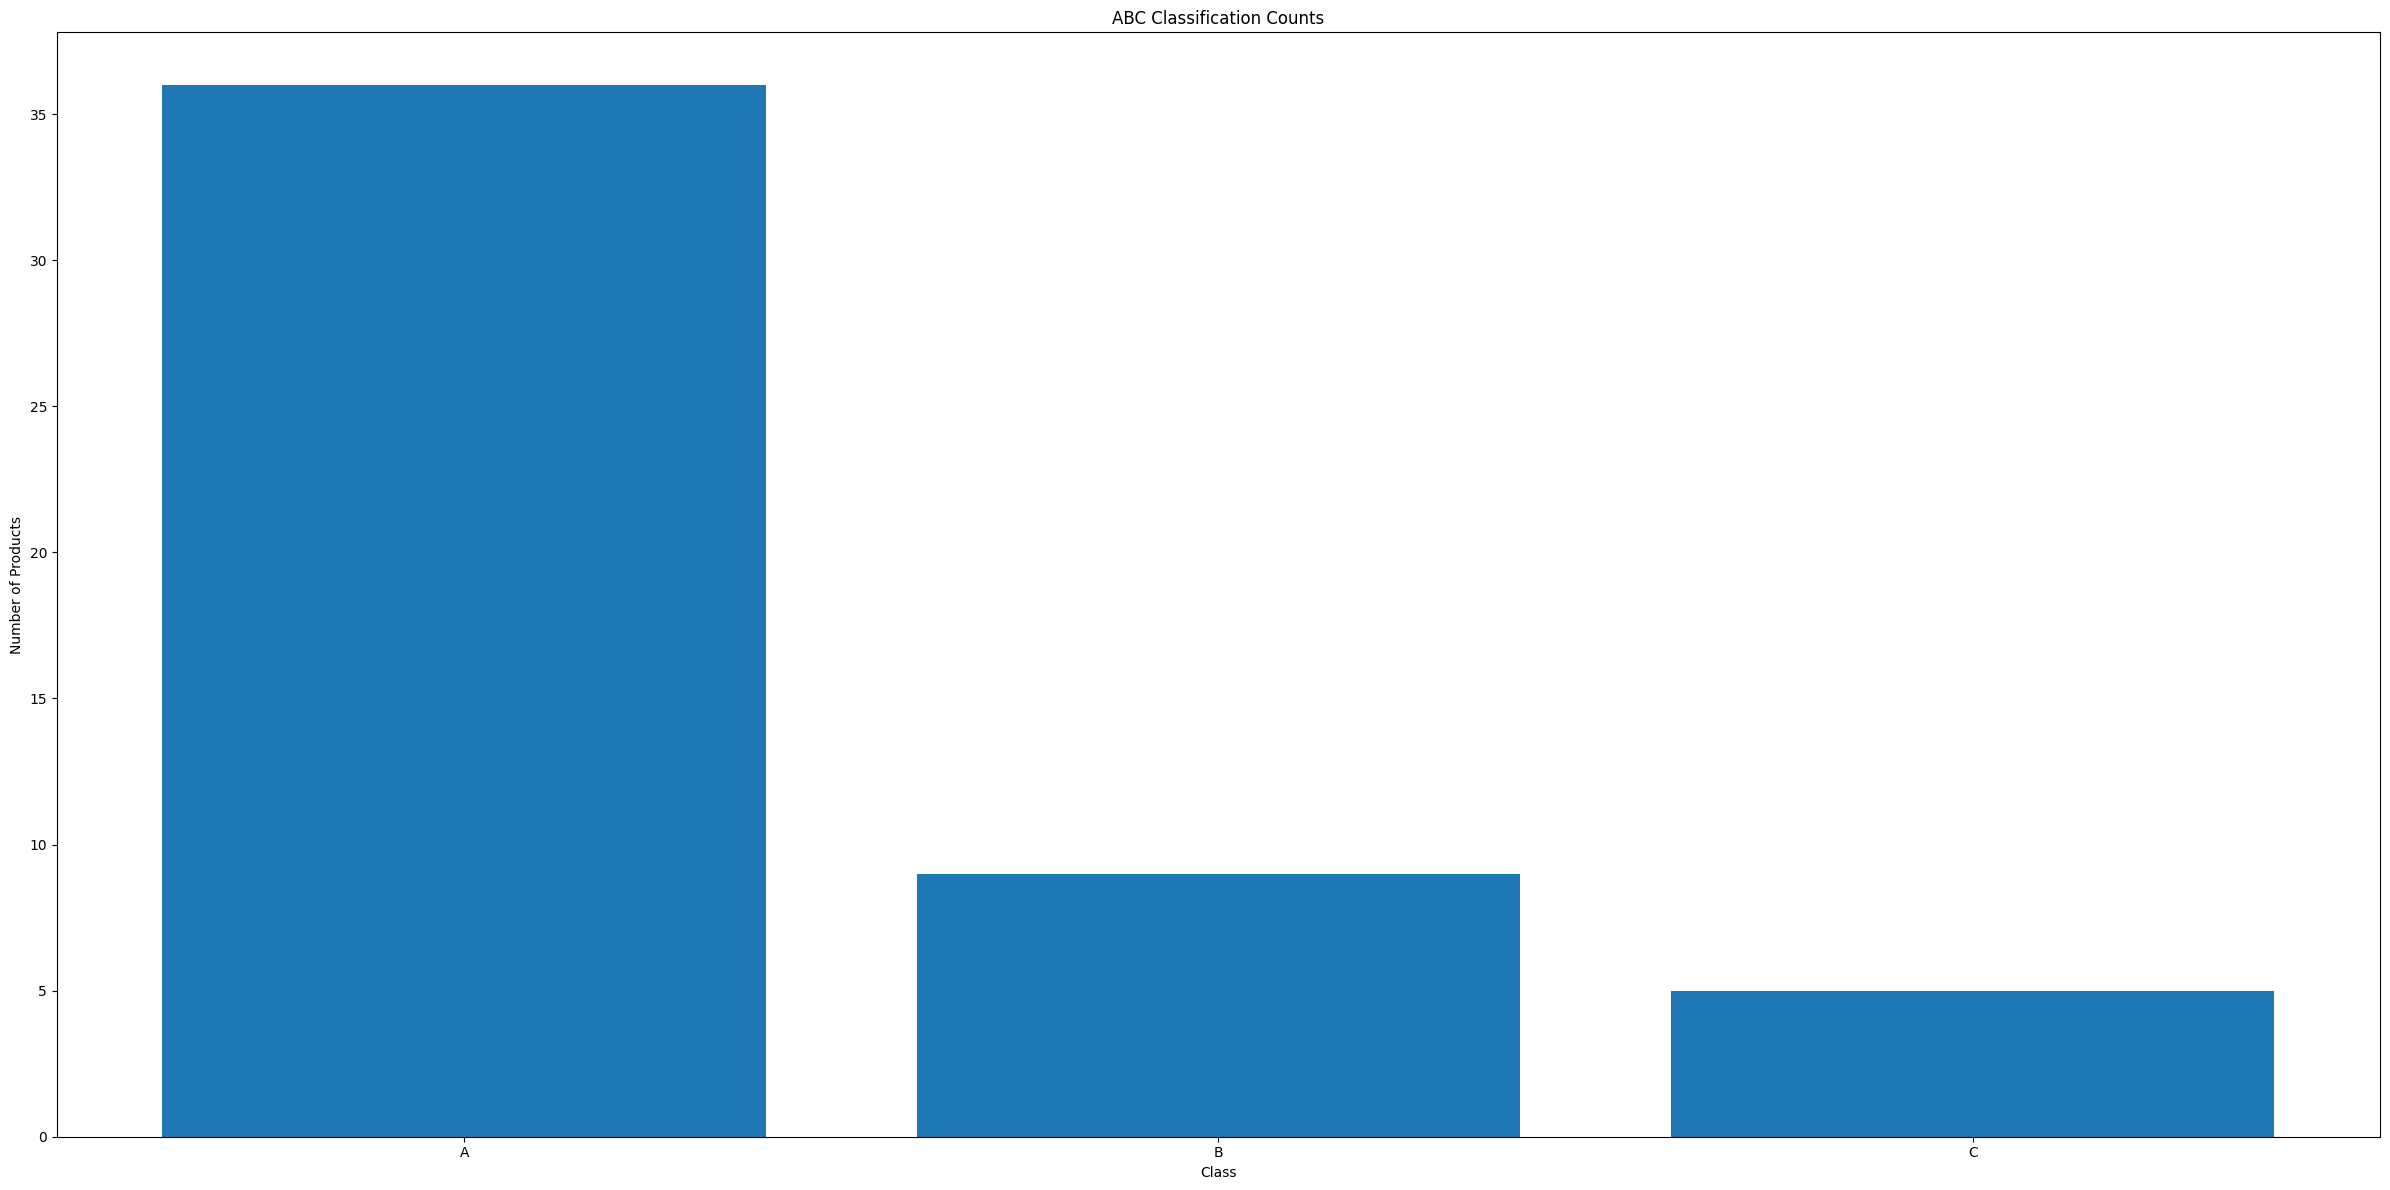

In [27]:
# revenue per product
rev_tot = rev.groupby('productId')['revenue'].sum().reset_index()
rev_tot = rev_tot.merge(df_products[['productId','productName']], on='productId').sort_values('revenue', ascending=False)
rev_tot['cumPct'] = rev_tot['revenue'].cumsum() / rev_tot['revenue'].sum() * 100

conds = [
    rev_tot['cumPct'] <= 80,
    rev_tot['cumPct'].between(80,95),
    rev_tot['cumPct'] > 95
]
choices = ['A','B','C']
rev_tot['ABC'] = np.select(conds, choices, default='C')

# count per class
abc_counts = rev_tot['ABC'].value_counts().sort_index()
plt.figure(figsize=(24,12))
plt.bar(abc_counts.index, abc_counts.values)
plt.title('ABC Classification Counts')
plt.xlabel('Class'); plt.ylabel('Number of Products')
plt.tight_layout()
plt.show()


## Demand Forecasting

Simple Holt–Winters on daily sales

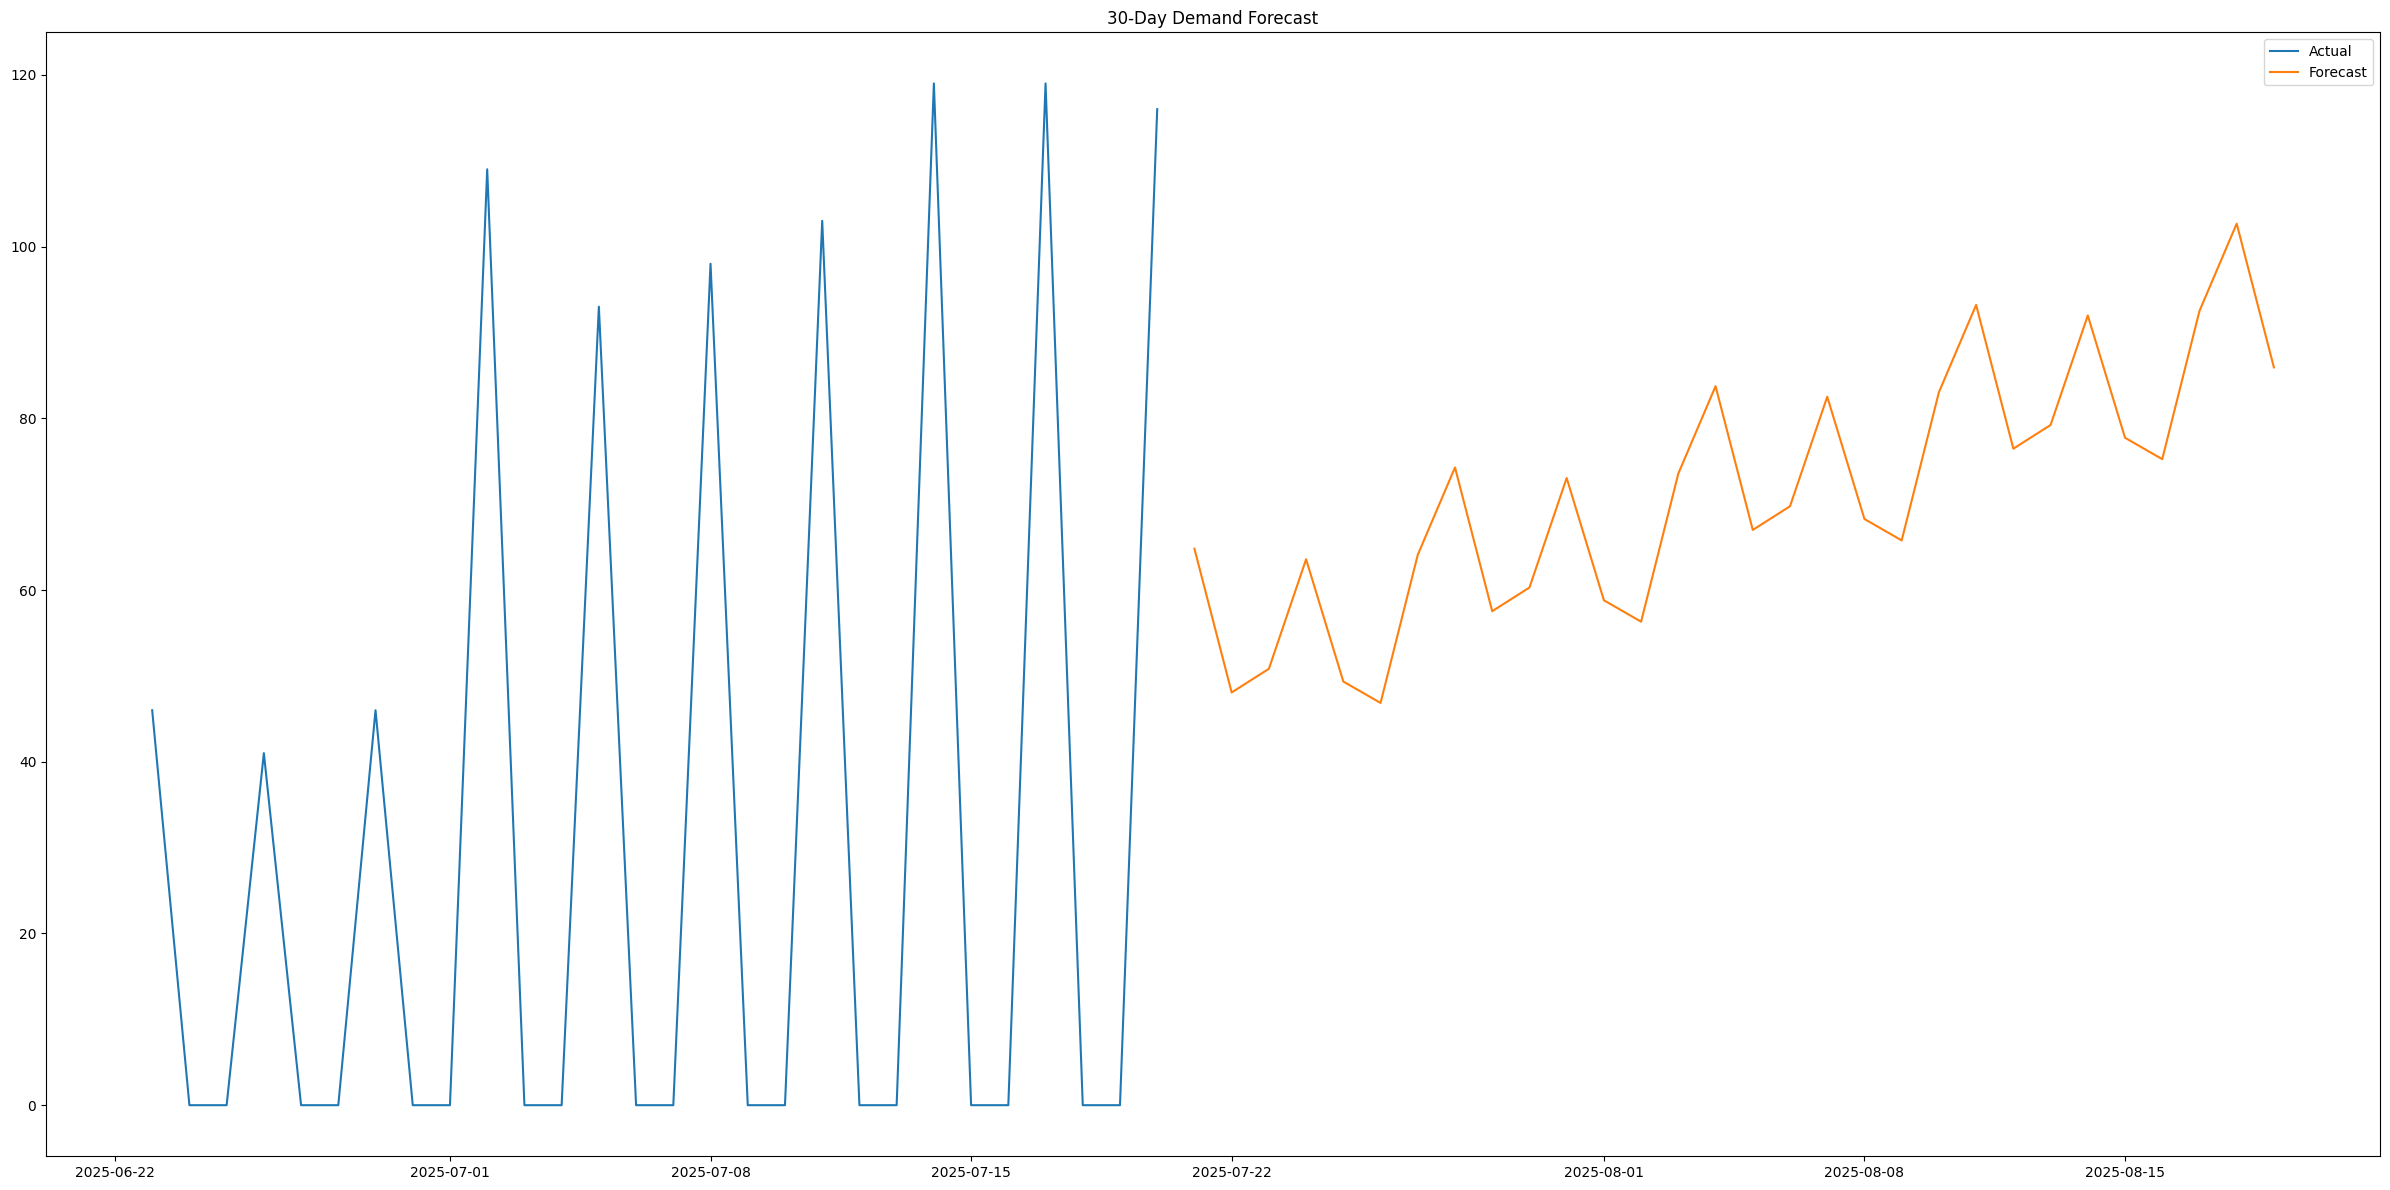

In [28]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

ts = sales.groupby('dateOrdered')['quantity'].sum().resample('D').sum().fillna(0)

model = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=7).fit()
forecast = model.forecast(30)

plt.figure(figsize=(24,12))
plt.plot(ts.index, ts, label='Actual')
plt.plot(forecast.index, forecast, label='Forecast')
plt.legend(); plt.title('30-Day Demand Forecast'); plt.tight_layout()
plt.show()


## Stockout Rate / Fill Rate

Approximate days when demand > stock

In [29]:
# daily demand vs. inventory at start of day
inv_daily = df_products.set_index('productId')['stockOnHand']  # snapshot; for rolling you'd need daily snapshots
# …for true fill rate you need back‐order data

# simpler: % of order lines where stockOnHand at order < quantityOrdered
merged = df_order_info.merge(df_products[['productId','stockOnHand']], on='productId')
stockouts = (merged['stockOnHand'] < merged['quantity']).mean() * 100
print(f"Stockout Rate (order‐lines): {stockouts:.1f}%")


Stockout Rate (order‐lines): 4.8%


## ROI of Inventory

In [30]:
# pick only the columns we need from products
price_cols = ['productId', 'cost', 'retailPrice']

orders = (
    df_order_info
    .merge(df_products[price_cols], on='productId', how='left')
)

orders['cogs']    = orders['quantity'] * orders['cost']
orders['revenue'] = orders['quantity'] * orders['retailPrice']

total_cogs    = orders['cogs'].sum()
total_revenue = orders['revenue'].sum()

# im under the assumption that 
# 'monetaryValue' = cost × stockOnHand already in Products Table
avg_inv_value = df_products['monetaryValue'].sum()

ROI = (total_revenue - total_cogs) / avg_inv_value * 100
print(f"Total Revenue: PHP{total_revenue:.2f}")
print(f"Total COGS: PHP{total_cogs:.2f}")
print(f"Avg Inventory Value: PHP{avg_inv_value:.2f}")
print(f"Inventory ROI: {ROI:.1f}%")


Total Revenue: PHP201551.74
Total COGS: PHP145500.11
Avg Inventory Value: PHP14213292.59
Inventory ROI: 0.4%


In [31]:
# theoretical revenue if you cleared out the warehouse
revenue    = (df_products['stockOnHand'] * df_products['retailPrice']).sum()
total_cogs = (df_products['stockOnHand'] * df_products['cost']).sum()
inv_value  = df_products['monetaryValue'].sum()   # = total_cogs

ROI_pct = (revenue - total_cogs) / inv_value * 100
print(f"Theoretical full-turn ROI: {ROI_pct:.1f}%")


Theoretical full-turn ROI: 2.6%


In [32]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_products)


     productId                                        productName  \
0            1                                          Product 1   
1            2                                          Product 2   
2            3                                          Product 3   
3            4                                          Product 4   
4            5                                          Product 5   
5            6                                          Product 6   
6            7                                          Product 7   
7            8                                          Product 8   
8            9                                          Product 9   
9           10                                         Product 10   
10          11                                         Product 11   
11          12                                         Product 12   
12          13                                         Product 13   
13          14                    

## Obsolete Inventory / Shrinkage

to check if certain items are obsolete na, not morving stock
pero to do that, we need to count the products that are physically present in one store

sige wag na lang siguro muna

In [33]:
# # df_physical with columns productId, countedUnits
# shrink = df_physical.set_index('productId')['countedUnits'] - df_products.set_index('productId')['stockOnHand']
# print(shrink.sort_values().head(10))  # largest negative = biggest shrinkage
